In [2]:
%load_ext autoreload
%autoreload 2


import matplotlib.pyplot as plt
plt.rcParams['image.cmap'] = 'gray'


In [3]:
import logging
logging.getLogger().setLevel(logging.DEBUG)

In [33]:
from torchsummary import summary
import torch
use_cuda=torch.cuda.is_available()
import pytorch
from pytorch import dataset as ptd

import os
import datasets
import pytorch_models
import torch.optim as optim
dataset_name="cifar10"
(x_train, y_train), (x_test, y_test), input_shape,num_classes = datasets.get_data(dataset_name)
dataset=ptd.ClassificationDataset(dataset_name,x_train,x_test,y_train,y_test,num_classes,input_shape)

print('x_train shape:', x_train.shape,x_train.dtype)
print('x_test shape:', x_test.shape,x_test.dtype)
print('y_train shape:', y_train.shape,y_train.dtype)
print('y_test shape:', y_test.shape,y_test.dtype)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')


import numpy as np
print(np.unique(y_train.argmax(axis=1)))
print(y_train.min(),y_train.max())


x_train shape: (50000, 32, 32, 3) uint8
x_test shape: (10000, 32, 32, 3) uint8
y_train shape: (50000, 10) float64
y_test shape: (10000, 10) float64
50000 train samples
10000 test samples
[0 1 2 3 4 5 6 7 8 9]
0.0 1.0


In [34]:
from pytorch import training

import pytorch_models

conv_filters={"mnist":32,"mnist_rot":32,"cifar10":64}
fc_filters={"mnist":64,"mnist_rot":64,"cifar10":128}
model = pytorch_models.SimpleConv(input_shape,num_classes,
                                 conv_filters=conv_filters[dataset.name],fc_filters=fc_filters[dataset.name])
#model= pytorch_models.FFNet(input_shape,num_classes)x
if use_cuda:
    model=model.cuda()
parameters=training.add_weight_decay(model.named_parameters(),1e-9)
optimizer = optim.Adam(parameters, lr=0.001)
print(model)

rotated_model= pytorch_models.SimpleConv(input_shape,num_classes,
                                       conv_filters=conv_filters[dataset.name],fc_filters=fc_filters[dataset.name])
if use_cuda:
    rotated_model= rotated_model.cuda()
rotated_parameters=training.add_weight_decay(rotated_model.named_parameters(),1e-9)
rotated_optimizer = optim.Adam(rotated_parameters, lr=0.001)

print(rotated_model)
#summary(model, input_size=[1,28,28])


SimpleConv(
  (conv): SequentialWithIntermediates(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
  )
  (fc): SequentialWithIntermediates(
    (0): Linear(in_features=16384, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=10, bias=True)
  )
)
SimpleConv(
  (conv): SequentialWithIntermediates(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1)

Training model with unrotated dataset...


Epoch 1: 100% (batch 782/782)  ==stats==> loss:   1.34, accuracy:  0.512, Time:  0:00:06


Test => Loss: 0.9629, Accuracy: 66.70% (6670/10000)


Epoch 2: 100% (batch 782/782)  ==stats==> loss:  0.821, accuracy:  0.711, Time:  0:00:06


Test => Loss: 0.7518, Accuracy: 73.35% (7335/10000)


Epoch 3: 100% (batch 782/782)  ==stats==> loss:  0.613, accuracy:  0.784, Time:  0:00:06


Test => Loss: 0.6783, Accuracy: 76.59% (7659/10000)


Epoch 4: 100% (batch 782/782)  ==stats==> loss:  0.456, accuracy:   0.84, Time:  0:00:06


Test => Loss: 0.6770, Accuracy: 78.04% (7804/10000)


Epoch 5: 100% (batch 782/782)  ==stats==> loss:  0.329, accuracy:  0.885, Time:  0:00:06


Test => Loss: 0.7048, Accuracy: 78.34% (7834/10000)


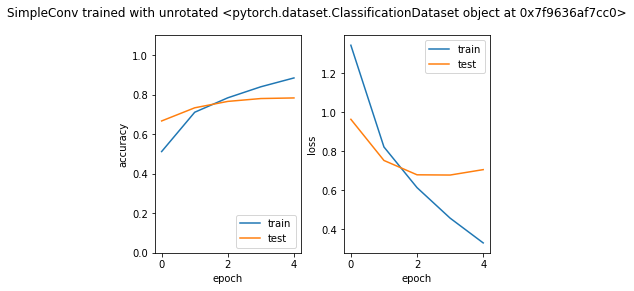

Skipping pretraining rotated model with unrotated dataset
Training rotated model with rotated dataset...


Epoch 1: 100% (batch 782/782)  ==stats==> loss:   1.87, accuracy:  0.309, Time:  0:00:09


Test => Loss: 1.6414, Accuracy: 40.51% (4051/10000)


Epoch 2: 100% (batch 782/782)  ==stats==> loss:    1.6, accuracy:   0.42, Time:  0:00:09


Test => Loss: 1.5509, Accuracy: 43.36% (4336/10000)


Epoch 3: 100% (batch 782/782)  ==stats==> loss:   1.48, accuracy:  0.463, Time:  0:00:09


Test => Loss: 1.4368, Accuracy: 48.20% (4820/10000)


Epoch 4: 100% (batch 782/782)  ==stats==> loss:    1.4, accuracy:  0.493, Time:  0:00:09


Test => Loss: 1.3682, Accuracy: 51.70% (5170/10000)


Epoch 5: 100% (batch 782/782)  ==stats==> loss:   1.33, accuracy:  0.521, Time:  0:00:09


Test => Loss: 1.3247, Accuracy: 53.19% (5319/10000)


Epoch 6: 100% (batch 782/782)  ==stats==> loss:   1.27, accuracy:  0.546, Time:  0:00:09


Test => Loss: 1.3216, Accuracy: 52.65% (5265/10000)


Epoch 7: 100% (batch 782/782)  ==stats==> loss:   1.23, accuracy:  0.557, Time:  0:00:09


Test => Loss: 1.2458, Accuracy: 56.20% (5620/10000)


Epoch 8: 100% (batch 782/782)  ==stats==> loss:   1.19, accuracy:  0.577, Time:  0:00:10


Test => Loss: 1.1964, Accuracy: 57.26% (5726/10000)


Epoch 9: 100% (batch 782/782)  ==stats==> loss:   1.15, accuracy:   0.59, Time:  0:00:09


Test => Loss: 1.1688, Accuracy: 58.82% (5882/10000)


Epoch 10: 100% (batch 782/782)  ==stats==> loss:   1.12, accuracy:  0.601, Time:  0:00:10


Test => Loss: 1.1475, Accuracy: 59.69% (5969/10000)


Epoch 11: 100% (batch 782/782)  ==stats==> loss:   1.09, accuracy:  0.615, Time:  0:00:10


Test => Loss: 1.1354, Accuracy: 59.87% (5987/10000)


Epoch 12: 100% (batch 782/782)  ==stats==> loss:   1.06, accuracy:  0.623, Time:  0:00:10


Test => Loss: 1.0910, Accuracy: 61.14% (6114/10000)


Epoch 13: 100% (batch 782/782)  ==stats==> loss:   1.04, accuracy:  0.632, Time:  0:00:10


Test => Loss: 1.0949, Accuracy: 61.27% (6127/10000)


Epoch 14: 100% (batch 782/782)  ==stats==> loss:   1.02, accuracy:  0.638, Time:  0:00:10


Test => Loss: 1.0627, Accuracy: 62.34% (6234/10000)


Epoch 15: 100% (batch 782/782)  ==stats==> loss:   1.01, accuracy:  0.644, Time:  0:00:09


Test => Loss: 1.0643, Accuracy: 62.66% (6266/10000)


Epoch 16: 100% (batch 782/782)  ==stats==> loss:   0.99, accuracy:  0.652, Time:  0:00:10


Test => Loss: 1.0568, Accuracy: 63.00% (6300/10000)


Epoch 17: 100% (batch 782/782)  ==stats==> loss:  0.971, accuracy:  0.657, Time:  0:00:10


Test => Loss: 1.0536, Accuracy: 63.42% (6342/10000)


Epoch 18: 100% (batch 782/782)  ==stats==> loss:  0.962, accuracy:  0.661, Time:  0:00:10


Test => Loss: 1.0396, Accuracy: 63.55% (6355/10000)


Epoch 19: 100% (batch 782/782)  ==stats==> loss:  0.957, accuracy:  0.662, Time:  0:00:09


Test => Loss: 1.0202, Accuracy: 64.48% (6448/10000)


Epoch 20: 100% (batch 782/782)  ==stats==> loss:  0.939, accuracy:  0.666, Time:  0:00:09


Test => Loss: 1.0585, Accuracy: 63.24% (6324/10000)


Epoch 21: 100% (batch 782/782)  ==stats==> loss:  0.926, accuracy:  0.671, Time:  0:00:10


Test => Loss: 0.9850, Accuracy: 65.64% (6564/10000)


Epoch 22: 100% (batch 782/782)  ==stats==> loss:   0.92, accuracy:  0.676, Time:  0:00:09


Test => Loss: 0.9932, Accuracy: 65.01% (6501/10000)


Epoch 23: 100% (batch 782/782)  ==stats==> loss:  0.902, accuracy:  0.683, Time:  0:00:10


Test => Loss: 1.0146, Accuracy: 64.04% (6404/10000)


Epoch 24: 100% (batch 782/782)  ==stats==> loss:  0.907, accuracy:  0.681, Time:  0:00:10


Test => Loss: 0.9855, Accuracy: 66.14% (6614/10000)


Epoch 25: 100% (batch 782/782)  ==stats==> loss:  0.894, accuracy:  0.686, Time:  0:00:09


Test => Loss: 0.9866, Accuracy: 65.59% (6559/10000)


Epoch 26: 100% (batch 782/782)  ==stats==> loss:  0.882, accuracy:  0.691, Time:  0:00:09


Test => Loss: 0.9677, Accuracy: 66.68% (6668/10000)


Epoch 27: 100% (batch 782/782)  ==stats==> loss:  0.874, accuracy:  0.692, Time:  0:00:10


Test => Loss: 0.9799, Accuracy: 65.84% (6584/10000)


Epoch 28: 100% (batch 782/782)  ==stats==> loss:  0.872, accuracy:  0.694, Time:  0:00:10


Test => Loss: 0.9769, Accuracy: 66.70% (6670/10000)


Epoch 29: 100% (batch 782/782)  ==stats==> loss:  0.861, accuracy:  0.699, Time:  0:00:09


Test => Loss: 0.9682, Accuracy: 66.44% (6644/10000)


Epoch 30: 100% (batch 782/782)  ==stats==> loss:  0.855, accuracy:  0.699, Time:  0:00:09


Test => Loss: 0.9559, Accuracy: 67.42% (6742/10000)


Epoch 31: 100% (batch 782/782)  ==stats==> loss:  0.848, accuracy:  0.703, Time:  0:00:09


Test => Loss: 1.0120, Accuracy: 65.47% (6547/10000)


Epoch 32: 100% (batch 782/782)  ==stats==> loss:  0.838, accuracy:  0.705, Time:  0:00:09


Test => Loss: 0.9755, Accuracy: 66.69% (6669/10000)


Epoch 33: 100% (batch 782/782)  ==stats==> loss:  0.834, accuracy:  0.707, Time:  0:00:09


Test => Loss: 0.9631, Accuracy: 66.62% (6662/10000)


Epoch 34: 100% (batch 782/782)  ==stats==> loss:  0.833, accuracy:  0.708, Time:  0:00:09


Test => Loss: 0.9727, Accuracy: 67.32% (6732/10000)


Epoch 35: 100% (batch 782/782)  ==stats==> loss:   0.82, accuracy:  0.713, Time:  0:00:10


Test => Loss: 0.9494, Accuracy: 68.05% (6805/10000)


Epoch 36: 100% (batch 782/782)  ==stats==> loss:  0.818, accuracy:  0.713, Time:  0:00:09


Test => Loss: 0.9714, Accuracy: 66.91% (6691/10000)


Epoch 37: 100% (batch 782/782)  ==stats==> loss:  0.822, accuracy:  0.713, Time:  0:00:10


Test => Loss: 0.9498, Accuracy: 67.52% (6752/10000)


Epoch 38: 100% (batch 782/782)  ==stats==> loss:  0.811, accuracy:  0.718, Time:  0:00:10


Test => Loss: 0.9423, Accuracy: 67.89% (6789/10000)


Epoch 39: 100% (batch 782/782)  ==stats==> loss:  0.807, accuracy:  0.718, Time:  0:00:09


Test => Loss: 0.9546, Accuracy: 67.66% (6766/10000)


Epoch 40: 100% (batch 782/782)  ==stats==> loss:  0.801, accuracy:  0.718, Time:  0:00:09


Test => Loss: 0.9564, Accuracy: 67.94% (6794/10000)


Epoch 41: 100% (batch 782/782)  ==stats==> loss:  0.799, accuracy:   0.72, Time:  0:00:10


Test => Loss: 0.9663, Accuracy: 67.20% (6720/10000)


Epoch 42: 100% (batch 782/782)  ==stats==> loss:  0.792, accuracy:  0.723, Time:  0:00:09


Test => Loss: 0.9305, Accuracy: 68.09% (6809/10000)


Epoch 43: 100% (batch 782/782)  ==stats==> loss:  0.786, accuracy:  0.723, Time:  0:00:10


Test => Loss: 0.9450, Accuracy: 67.63% (6763/10000)


Epoch 44: 100% (batch 782/782)  ==stats==> loss:  0.785, accuracy:  0.724, Time:  0:00:09


Test => Loss: 0.9416, Accuracy: 68.49% (6849/10000)


Epoch 45: 100% (batch 782/782)  ==stats==> loss:  0.785, accuracy:  0.724, Time:  0:00:09


Test => Loss: 0.9250, Accuracy: 68.06% (6806/10000)


Epoch 46: 100% (batch 782/782)  ==stats==> loss:  0.777, accuracy:  0.729, Time:  0:00:10


Test => Loss: 0.9246, Accuracy: 68.84% (6884/10000)


Epoch 47: 100% (batch 782/782)  ==stats==> loss:  0.772, accuracy:   0.73, Time:  0:00:10


Test => Loss: 0.9344, Accuracy: 68.54% (6854/10000)


Epoch 48: 100% (batch 782/782)  ==stats==> loss:   0.77, accuracy:   0.73, Time:  0:00:09


Test => Loss: 0.9482, Accuracy: 68.29% (6829/10000)


Epoch 49: 100% (batch 782/782)  ==stats==> loss:  0.762, accuracy:  0.733, Time:  0:00:10


Test => Loss: 0.9848, Accuracy: 67.05% (6705/10000)


Epoch 50: 100% (batch 782/782)  ==stats==> loss:  0.758, accuracy:  0.735, Time:  0:00:09


Test => Loss: 0.9421, Accuracy: 68.80% (6880/10000)


Epoch 51: 100% (batch 782/782)  ==stats==> loss:  0.754, accuracy:  0.737, Time:  0:00:09


Test => Loss: 0.9272, Accuracy: 68.74% (6874/10000)


Epoch 52: 100% (batch 782/782)  ==stats==> loss:  0.758, accuracy:  0.734, Time:  0:00:09


Test => Loss: 0.9246, Accuracy: 68.50% (6850/10000)


Epoch 53: 100% (batch 782/782)  ==stats==> loss:  0.751, accuracy:  0.736, Time:  0:00:10


Test => Loss: 0.9423, Accuracy: 68.81% (6881/10000)


Epoch 54: 100% (batch 782/782)  ==stats==> loss:  0.745, accuracy:   0.74, Time:  0:00:10


Test => Loss: 0.9327, Accuracy: 68.60% (6860/10000)


Epoch 55: 100% (batch 782/782)  ==stats==> loss:  0.749, accuracy:  0.738, Time:  0:00:10


Test => Loss: 0.9221, Accuracy: 69.00% (6900/10000)


Epoch 56: 100% (batch 782/782)  ==stats==> loss:  0.741, accuracy:  0.741, Time:  0:00:09


Test => Loss: 0.9375, Accuracy: 68.36% (6836/10000)


Epoch 57: 100% (batch 782/782)  ==stats==> loss:  0.742, accuracy:   0.74, Time:  0:00:09


Test => Loss: 0.9583, Accuracy: 68.39% (6839/10000)


Epoch 58: 100% (batch 782/782)  ==stats==> loss:  0.737, accuracy:  0.744, Time:  0:00:09


Test => Loss: 0.9239, Accuracy: 68.59% (6859/10000)


Epoch 59: 100% (batch 782/782)  ==stats==> loss:  0.738, accuracy:  0.739, Time:  0:00:09


Test => Loss: 0.9183, Accuracy: 69.12% (6912/10000)


Epoch 60: 100% (batch 782/782)  ==stats==> loss:   0.73, accuracy:  0.745, Time:  0:00:10


Test => Loss: 0.9352, Accuracy: 68.82% (6882/10000)


Epoch 61: 100% (batch 782/782)  ==stats==> loss:  0.728, accuracy:  0.745, Time:  0:00:10


Test => Loss: 0.9397, Accuracy: 68.11% (6811/10000)


Epoch 62: 100% (batch 782/782)  ==stats==> loss:  0.732, accuracy:  0.744, Time:  0:00:09


Test => Loss: 0.9347, Accuracy: 69.12% (6912/10000)


Epoch 63: 100% (batch 782/782)  ==stats==> loss:  0.721, accuracy:  0.747, Time:  0:00:10


Test => Loss: 0.9357, Accuracy: 68.97% (6897/10000)


Epoch 64: 100% (batch 782/782)  ==stats==> loss:  0.722, accuracy:  0.748, Time:  0:00:09


Test => Loss: 0.9276, Accuracy: 68.76% (6876/10000)


Epoch 65: 100% (batch 782/782)  ==stats==> loss:  0.721, accuracy:  0.749, Time:  0:00:09


Test => Loss: 0.9406, Accuracy: 69.10% (6910/10000)


Epoch 66: 100% (batch 782/782)  ==stats==> loss:  0.716, accuracy:  0.749, Time:  0:00:09


Test => Loss: 0.9293, Accuracy: 68.67% (6867/10000)


Epoch 67: 100% (batch 782/782)  ==stats==> loss:  0.717, accuracy:  0.751, Time:  0:00:09


Test => Loss: 0.9218, Accuracy: 69.17% (6917/10000)


Epoch 68: 100% (batch 782/782)  ==stats==> loss:   0.71, accuracy:  0.752, Time:  0:00:09


Test => Loss: 0.9452, Accuracy: 69.07% (6907/10000)


Epoch 69: 100% (batch 782/782)  ==stats==> loss:  0.714, accuracy:  0.751, Time:  0:00:10


Test => Loss: 0.9393, Accuracy: 68.60% (6860/10000)


Epoch 70: 100% (batch 782/782)  ==stats==> loss:  0.712, accuracy:  0.752, Time:  0:00:09


Test => Loss: 0.8868, Accuracy: 70.54% (7054/10000)


Epoch 71: 100% (batch 782/782)  ==stats==> loss:  0.707, accuracy:  0.753, Time:  0:00:09


Test => Loss: 0.9221, Accuracy: 69.75% (6975/10000)


Epoch 72: 100% (batch 782/782)  ==stats==> loss:   0.71, accuracy:  0.756, Time:  0:00:10


Test => Loss: 0.9284, Accuracy: 69.80% (6980/10000)


Epoch 73: 100% (batch 782/782)  ==stats==> loss:  0.699, accuracy:  0.758, Time:  0:00:09


Test => Loss: 0.9380, Accuracy: 68.89% (6889/10000)


Epoch 74: 100% (batch 782/782)  ==stats==> loss:  0.705, accuracy:  0.754, Time:  0:00:09


Test => Loss: 0.9356, Accuracy: 69.27% (6927/10000)


Epoch 75: 100% (batch 782/782)  ==stats==> loss:  0.697, accuracy:  0.756, Time:  0:00:10


Test => Loss: 0.9341, Accuracy: 69.32% (6932/10000)


Epoch 76: 100% (batch 782/782)  ==stats==> loss:  0.701, accuracy:  0.755, Time:  0:00:09


Test => Loss: 0.9206, Accuracy: 69.25% (6925/10000)


Epoch 77: 100% (batch 782/782)  ==stats==> loss:  0.696, accuracy:  0.756, Time:  0:00:09


Test => Loss: 0.9042, Accuracy: 69.19% (6919/10000)


Epoch 78: 100% (batch 782/782)  ==stats==> loss:  0.696, accuracy:  0.758, Time:  0:00:09


Test => Loss: 0.9420, Accuracy: 69.13% (6913/10000)


Epoch 79: 100% (batch 782/782)  ==stats==> loss:  0.696, accuracy:  0.758, Time:  0:00:10


Test => Loss: 0.9308, Accuracy: 69.86% (6986/10000)


Epoch 80: 100% (batch 782/782)  ==stats==> loss:  0.695, accuracy:   0.76, Time:  0:00:09


Test => Loss: 0.9215, Accuracy: 70.12% (7012/10000)


Epoch 81: 100% (batch 782/782)  ==stats==> loss:  0.691, accuracy:  0.761, Time:  0:00:09


Test => Loss: 0.9068, Accuracy: 69.81% (6981/10000)


Epoch 82: 100% (batch 782/782)  ==stats==> loss:  0.688, accuracy:  0.758, Time:  0:00:10


Test => Loss: 0.8872, Accuracy: 70.38% (7038/10000)


Epoch 83: 100% (batch 782/782)  ==stats==> loss:  0.684, accuracy:  0.759, Time:  0:00:09


Test => Loss: 0.9162, Accuracy: 69.83% (6983/10000)


Epoch 84: 100% (batch 782/782)  ==stats==> loss:  0.681, accuracy:  0.762, Time:  0:00:10


Test => Loss: 0.9404, Accuracy: 68.90% (6890/10000)


Epoch 85: 100% (batch 782/782)  ==stats==> loss:  0.687, accuracy:   0.76, Time:  0:00:09


Test => Loss: 0.9147, Accuracy: 70.10% (7010/10000)


Epoch 86: 100% (batch 782/782)  ==stats==> loss:   0.68, accuracy:  0.763, Time:  0:00:10


Test => Loss: 0.9067, Accuracy: 70.64% (7064/10000)


Epoch 87: 100% (batch 782/782)  ==stats==> loss:  0.678, accuracy:  0.763, Time:  0:00:09


Test => Loss: 0.9237, Accuracy: 69.44% (6944/10000)


Epoch 88: 100% (batch 782/782)  ==stats==> loss:  0.676, accuracy:  0.765, Time:  0:00:09


Test => Loss: 0.9204, Accuracy: 70.18% (7018/10000)


Epoch 89: 100% (batch 782/782)  ==stats==> loss:  0.677, accuracy:  0.765, Time:  0:00:09


Test => Loss: 0.9024, Accuracy: 70.28% (7028/10000)


Epoch 90: 100% (batch 782/782)  ==stats==> loss:  0.675, accuracy:  0.765, Time:  0:00:10


Test => Loss: 0.9275, Accuracy: 69.18% (6918/10000)


Epoch 91: 100% (batch 782/782)  ==stats==> loss:  0.674, accuracy:  0.768, Time:  0:00:10


Test => Loss: 0.9456, Accuracy: 68.91% (6891/10000)


Epoch 92: 100% (batch 782/782)  ==stats==> loss:  0.679, accuracy:  0.764, Time:  0:00:09


Test => Loss: 0.9162, Accuracy: 69.71% (6971/10000)


Epoch 93: 100% (batch 782/782)  ==stats==> loss:   0.67, accuracy:  0.766, Time:  0:00:10


Test => Loss: 0.9183, Accuracy: 70.23% (7023/10000)


Epoch 94: 100% (batch 782/782)  ==stats==> loss:  0.667, accuracy:  0.766, Time:  0:00:09


Test => Loss: 0.9311, Accuracy: 69.46% (6946/10000)


Epoch 95: 100% (batch 782/782)  ==stats==> loss:  0.671, accuracy:  0.766, Time:  0:00:09


Test => Loss: 0.9058, Accuracy: 70.08% (7008/10000)


Epoch 96: 100% (batch 782/782)  ==stats==> loss:  0.664, accuracy:  0.768, Time:  0:00:10


Test => Loss: 0.9167, Accuracy: 70.49% (7049/10000)


Epoch 97: 100% (batch 782/782)  ==stats==> loss:  0.668, accuracy:  0.766, Time:  0:00:10


Test => Loss: 0.9143, Accuracy: 69.67% (6967/10000)


Epoch 98: 100% (batch 782/782)  ==stats==> loss:  0.665, accuracy:  0.767, Time:  0:00:09


Test => Loss: 0.9134, Accuracy: 70.27% (7027/10000)


Epoch 99: 100% (batch 782/782)  ==stats==> loss:  0.659, accuracy:  0.771, Time:  0:00:10


Test => Loss: 0.9124, Accuracy: 70.00% (7000/10000)


Epoch 100: 100% (batch 782/782)  ==stats==> loss:   0.66, accuracy:  0.771, Time:  0:00:09


Test => Loss: 0.9268, Accuracy: 70.21% (7021/10000)


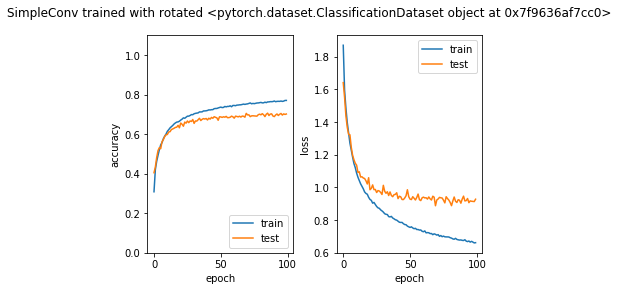

Testing both models on both datasets...


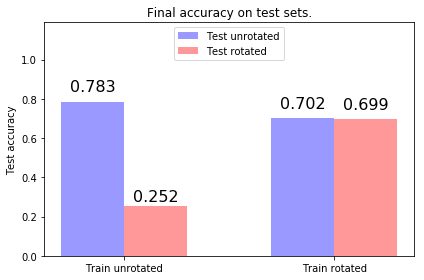

model_rotated_test_dataset score: loss=4.419044, accuracy=0.251700
model_rotated_train_dataset score: loss=4.422210, accuracy=0.252580
model_test_dataset score: loss=0.704781, accuracy=0.783400
model_train_dataset score: loss=0.209965, accuracy=0.932840
rotated_model_rotated_test_dataset score: loss=0.928102, accuracy=0.699300
rotated_model_rotated_train_dataset score: loss=0.631986, accuracy=0.777180
rotated_model_test_dataset score: loss=0.937364, accuracy=0.701800
rotated_model_train_dataset score: loss=0.653631, accuracy=0.772860


In [35]:
batch_size = 64

epochs={'cifar10':5,'mnist':2,'fashion_mnist':12,'cluttered_mnist':10,'lsa16':15,'mnist_rot':5,'pugeault':15}
from pytorch.experiment import rotation
rotated_epochs={'cifar10':100,'mnist':2,'fashion_mnist':60,'cluttered_mnist':30,'lsa16':100,'mnist_rot':5,'pugeault':40}

config=pytorch.experiment.rotation.TrainRotatedConfig(dataset_name=dataset,batch_size=batch_size,
                   epochs=epochs[dataset.name],rotated_epochs=rotated_epochs[dataset.name],
                   pre_rotated_epochs=0, optimizer=optimizer,rotated_optimizer=rotated_optimizer,
                  use_cuda=use_cuda)

scores=rotation.run(config,model,rotated_model,
                                        x_train,y_train,x_test,y_test,plot_accuracy=True,save_plots=False)
for k,v in scores.items():
    print('%s score: loss=%f, accuracy=%f' % (k,v[0],v[1]))


In [30]:
from pytorch.experiment import invariance_evaluation

n_rotations=16
#results=invariance_evaluation.run(model,dataset,config)
rotated_results,classes,rotations=invariance_evaluation.run(rotated_model,dataset,config,n_rotations)
results,classes,rotations=invariance_evaluation.run(model,dataset,config,n_rotations)




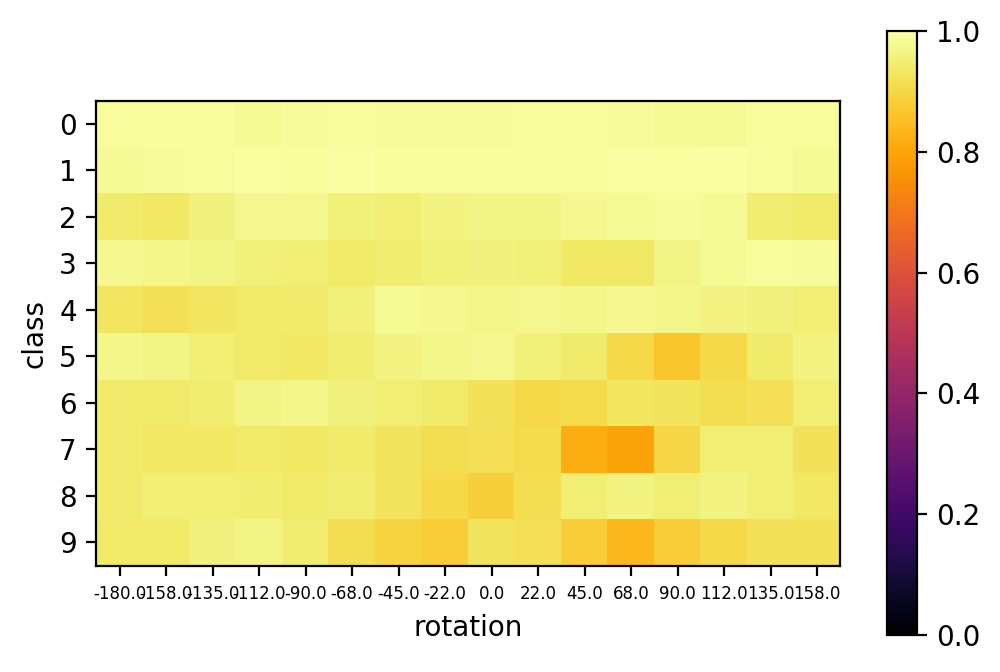

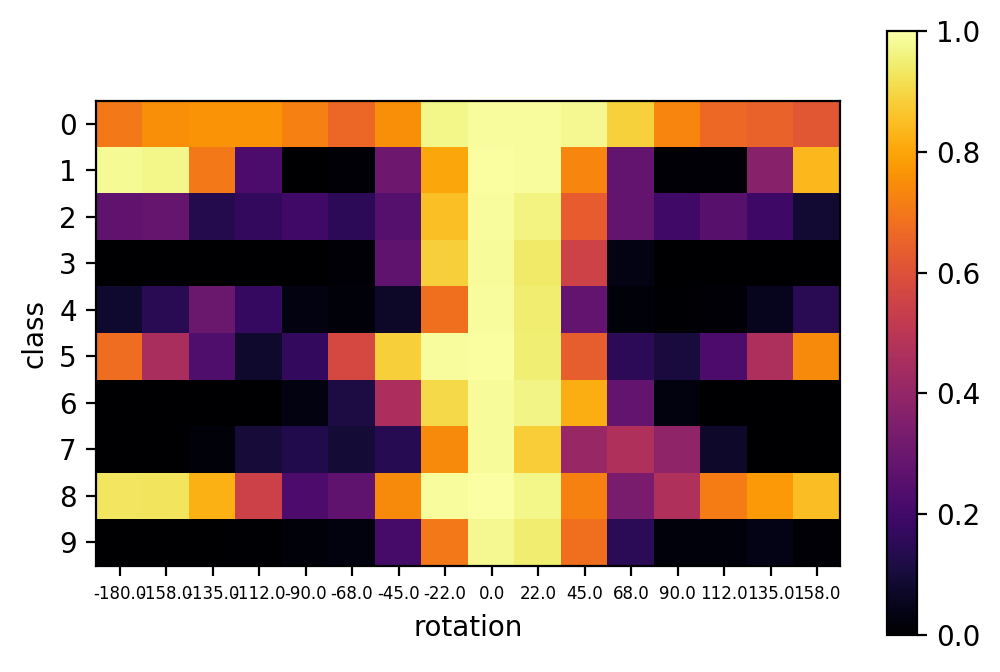

In [32]:
base_folder="plots/invariance_evaluation"
rotated_fig=invariance_evaluation.plot_results(rotated_results,classes,rotations)
name=f"{base_folder}/{dataset.name}_{model.name}_rotated.png"
rotated_fig.savefig(name)

fig=invariance_evaluation.plot_results(results,classes,rotations)
name=f"{base_folder}/{dataset.name}_{model.name}_unrotated.png"
fig.savefig(name)
